 - Name : Kaustubh Arun Shingana
 - Roll Number : E21008

In [9]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, accuracy_score, confusion_matrix 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()
import talib as ta

In [10]:
#Reading BANKNIFTY Data
df = pdr.get_data_yahoo('^NSEBANK', '2000-01-01', '2021-08-15')
df = df.dropna()
df = df.iloc[:,:4]
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close
Date,,,,
2007-09-17,6898.000000,6977.200195,6843.000000,6897.100098
2007-09-18,6921.149902,7078.950195,6883.600098,7059.649902
2007-09-19,7111.000000,7419.350098,7111.000000,7401.850098
2007-09-20,7404.950195,7462.899902,7343.600098,7390.149902
2007-09-21,7378.299805,7506.350098,7367.149902,7464.500000


We will use 10-days moving average, correlation, relative strength index (RSI), the difference between the open price of yesterday and today, difference close price of yesterday and the open price of today, open, high, low, and close price as indicators to make the prediction.

In [28]:
#Simple Moving Average
df['S_10'] = df['Close'].rolling(window=10).mean()

In [29]:
#Corr w.r.t SMA 10
df['Corr'] = df['Close'].rolling(window=10).corr(df['S_10'])

In [11]:
#Making RSI Indicator
df['RSI'] = ta.RSI(np.array(df['Close']), timeperiod =10)

In [13]:
# Yesterday Close - Open Price
df['Open-Close'] = df['Open'] - df['Close'].shift(1)
df['Open-Open'] = df['Open'] - df['Open'].shift(1)


In [14]:
df = df.dropna()

In [16]:
X = df.iloc[:,:9]
X

,Open,High,Low,Close,RSI,Open-Close,Open-Open
Date,,,,,,,
2007-10-01,8008.549805,8085.149902,7913.299805,7987.500000,93.040946,-33.650391,170.299805
2007-10-03,8029.799805,8235.799805,7820.250000,8097.899902,93.655357,42.299805,21.250000
2007-10-04,8083.299805,8086.700195,7828.649902,8035.899902,88.765098,-14.600098,53.500000
2007-10-05,8038.100098,8066.549805,7789.700195,7845.250000,75.326620,2.200195,-45.199707
2007-10-08,7853.149902,7935.450195,7516.450195,7626.399902,63.135370,7.899902,-184.950195
...,...,...,...,...,...,...,...
2021-08-09,35824.199219,36159.851562,35612.300781,36028.949219,64.984920,14.949219,-51.601562
2021-08-10,35954.550781,36317.000000,35890.500000,36034.101562,65.058096,-74.398438,130.351562
2021-08-11,36218.250000,36227.550781,35531.351562,35806.398438,59.003103,184.148438,263.699219


The simple Strategy is, If tomorrow’s closing price is higher than today’s closing price, then we will buy the stock (1), else we will sell it (-1).
so lets define the strategy andd putting the same in df


In [17]:
y = np.where(df['Close'].shift(-1) > df['Close'],1,-1)

In [19]:
#making train test split
split = int(0.7*len(df))
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]

In [21]:
#Fitting Logistics Regression model to train
model = LogisticRegression()
model = model.fit (X_train,y_train)

In [22]:
#after fitting the model, lets check the coeff of the model
pd.DataFrame(zip(X.columns, np.transpose(model.coef_)))

,0,1
0,Open,[-0.0014193151081736124]
1,High,[0.0007235049292818937]
2,Low,[0.0008105051462531683]
3,Close,[-0.00010784161163547046]
4,RSI,[2.171917774233977e-05]
5,Open-Close,[0.0006793375442596124]
6,Open-Open,[4.223895003341291e-05]


In [24]:
#checking the Probabilituy on the Test data
probability = model.predict_proba(X_test)
print (probability)

[[0.47056672 0.52943328]
 [0.44592887 0.55407113]
 [0.37631283 0.62368717]
 ...
 [0.52992617 0.47007383]
 [0.43614197 0.56385803]
 [0.40195869 0.59804131]]


we will have to predict the classs labels using predict function for the test dataset.

In [25]:
probability = model.predict_proba(X_test)

In [26]:
print(probability)

[[0.47056672 0.52943328]
 [0.44592887 0.55407113]
 [0.37631283 0.62368717]
 ...
 [0.52992617 0.47007383]
 [0.43614197 0.56385803]
 [0.40195869 0.59804131]]


In [31]:
predicted = model.predict(X_test)
predicted[:15]

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1])

we can see that the Labels are being predicted based on the strategy we have given to the model, so when P(>0.5) then array will return 1
when the p(<0.5) the array will return -1 signal

### Model Evaluation

In [32]:
print(metrics.confusion_matrix(y_test, predicted))

[[104 338]
 [112 382]]


better way to analyse Confustion Matrix is :

In [34]:
print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

          -1       0.48      0.24      0.32       442
           1       0.53      0.77      0.63       494

    accuracy                           0.52       936
   macro avg       0.51      0.50      0.47       936
weighted avg       0.51      0.52      0.48       936



The f1-score tells you the accuracy of the classifier in classifying the data points in that particular class compared to all other class. It is calculated by taking the harmonic mean of precision and recall. The support is the number of samples of the true response that lies in that class.
here, F1 score is 0.52

In [35]:
print(model.score(X_test,y_test))

0.5192307692307693


so, we can say that, model is able to predict with 52% accuracy

In [36]:
#To increase the accuracy, we can add k-fold cross validation to the model
cross_val = cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=10)

In [37]:
print(cross_val)

[0.52884615 0.5        0.53205128 0.53525641 0.5        0.50641026
 0.50961538 0.53205128 0.5        0.50482315]


In [38]:
print(cross_val.mean())

0.514905392035617


#### After the Cross Validation also, we are not getting the accuracy more than 52%
we need to plot the chart to see the overall performance w.r.t underlyying prices of the BankMifty

In [39]:
df['Predicted_Signal'] = model.predict(X)

In [45]:
df['Bank Nifty_returns'] = np.log(df['Close']/df['Close'].shift(1))

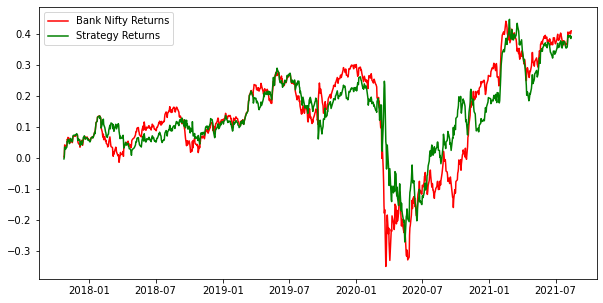

In [46]:
Cumulative_Nifty_returns = np.cumsum(df[split:]['Bank Nifty_returns'])
df['Startegy_returns'] = df['Bank Nifty_returns']* df['Predicted_Signal'].shift(1)
Cumulative_Strategy_returns = np.cumsum(df[split:]['Startegy_returns'])
plt.figure(figsize=(10,5))
plt.plot(Cumulative_Nifty_returns, color='r',label = 'Bank Nifty Returns')
plt.plot(Cumulative_Strategy_returns, color='g', label = 'Strategy Returns')
plt.legend()
plt.show()

we can see that the Strategy is not that fit with the model

